# POS tagging using modified Viterbi

### Data Preparation

In [1]:
#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [2]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [3]:
# first few tagged sentences
print(nltk_data[:20])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [4]:
# Splitting into train and test
random.seed(1234)
train_set, test_set = train_test_split(nltk_data,test_size=0.05)

print(len(train_set))
print(len(test_set))
print(train_set[:40])

3718
196
[[('Several', 'ADJ'), ('years', 'NOUN'), ('ago', 'ADP'), ('he', 'PRON'), ('gave', 'VERB'), ('up', 'PRT'), ('*-3', 'X'), ('trying', 'VERB'), ('*-1', 'X'), ('to', 'PRT'), ('persuade', 'VERB'), ('Miami', 'NOUN'), ('*-2', 'X'), ('to', 'PRT'), ('improve', 'VERB'), ('its', 'PRON'), ('city-owned', 'ADJ'), ('Orange', 'NOUN'), ('Bowl', 'NOUN'), (',', '.'), ('and', 'CONJ'), ('instead', 'ADV'), ('built', 'VERB'), ('his', 'PRON'), ('own', 'ADJ'), ('$', '.'), ('100', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('coliseum', 'NOUN'), ('with', 'ADP'), ('private', 'ADJ'), ('funds', 'NOUN'), ('.', '.')], [('In', 'ADP'), ('this', 'DET'), ('one', 'NOUN'), (',', '.'), ('the', 'DET'), ('screen', 'NOUN'), ('fills', 'VERB'), ('with', 'ADP'), ('photographs', 'NOUN'), ('of', 'ADP'), ('both', 'DET'), ('candidates', 'NOUN'), ('.', '.')], [('The', 'DET'), ('materials', 'NOUN'), ('in', 'ADP'), ('each', 'DET'), ('set', 'NOUN'), ('reach', 'VERB'), ('about', 'ADP'), ('90', 'NUM'), ('students', 'NOUN'), ('.', '.

In [5]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95462

In [6]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['Several', 'years', 'ago', 'he', 'gave', 'up', '*-3', 'trying', '*-1', 'to']

In [7]:
# vocabulary
V = set(tokens)
print(len(V))

12055


In [8]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
len(T)

12

In [9]:
print(T)

{'PRT', 'PRON', 'X', 'ADJ', 'ADV', 'ADP', '.', 'CONJ', 'DET', 'NUM', 'NOUN', 'VERB'}


### Emission Probabilities

In [10]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [11]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

### Transition Probabilities

In [12]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [13]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [14]:
tags_matrix

array([[1.97433378e-03, 1.87561698e-02, 1.28331687e-02, 8.55544582e-02,
        1.05297798e-02, 1.94142815e-02, 4.24481742e-02, 1.64527807e-03,
        1.02007240e-01, 5.62685095e-02, 2.46791705e-01, 4.01776910e-01],
       [1.22652361e-02, 7.66577246e-03, 9.27558467e-02, 7.47412816e-02,
        3.52625512e-02, 2.22307406e-02, 4.06285934e-02, 5.36604086e-03,
        9.58221499e-03, 6.89919526e-03, 2.07742423e-01, 4.84860092e-01],
       [1.84411854e-01, 5.54670058e-02, 7.49123394e-02, 1.67357344e-02,
        2.66177878e-02, 1.45521194e-01, 1.63053870e-01, 1.05196051e-02,
        5.33949621e-02, 2.86898320e-03, 6.20019138e-02, 2.04494745e-01],
       [1.12303877e-02, 6.60611084e-04, 2.04789434e-02, 6.75474778e-02,
        4.78943018e-03, 7.76218027e-02, 6.50701895e-02, 1.66804288e-02,
        4.95458301e-03, 2.09744014e-02, 6.97770417e-01, 1.22213047e-02],
       [1.39072845e-02, 1.49006620e-02, 2.35099345e-02, 1.29801318e-01,
        7.81456977e-02, 1.19205296e-01, 1.39072850e-01, 6.95

In [15]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [16]:
tags_df

,PRT,PRON,X,ADJ,ADV,ADP,.,CONJ,DET,NUM,NOUN,VERB
PRT,0.001974,0.018756,0.012833,0.085554,0.010530,0.019414,0.042448,0.001645,0.102007,0.056269,0.246792,0.401777
PRON,0.012265,0.007666,0.092756,0.074741,0.035263,0.022231,0.040629,0.005366,0.009582,0.006899,0.207742,0.484860
X,0.184412,0.055467,0.074912,0.016736,0.026618,0.145521,0.163054,0.010520,0.053395,0.002869,0.062002,0.204495
ADJ,0.011230,0.000661,0.020479,0.067547,0.004789,0.077622,0.065070,0.016680,0.004955,0.020974,0.697770,0.012221
ADV,0.013907,0.014901,0.023510,0.129801,0.078146,0.119205,0.139073,0.006954,0.067550,0.031457,0.030795,0.344702
ADP,0.001395,0.069213,0.034875,0.105913,0.013843,0.016955,0.039704,0.000858,0.323854,0.062024,0.322889,0.008477
.,0.002513,0.065967,0.026566,0.043260,0.052504,0.090109,0.093520,0.058697,0.173218,0.082211,0.222671,0.088673
CONJ,0.005140,0.059346,0.007944,0.116822,0.055140,0.054206,0.034579,0.000467,0.121495,0.042523,0.345327,0.157009
DET,0.000242,0.003516,0.046314,0.204413,0.012245,0.009093,0.017823,0.000485,0.005092,0.022915,0.638215,0.039646
NUM,0.025694,0.001477,0.212345,0.033373,0.002067,0.035440,0.114885,0.012404,0.003249,0.184584,0.356468,0.018015


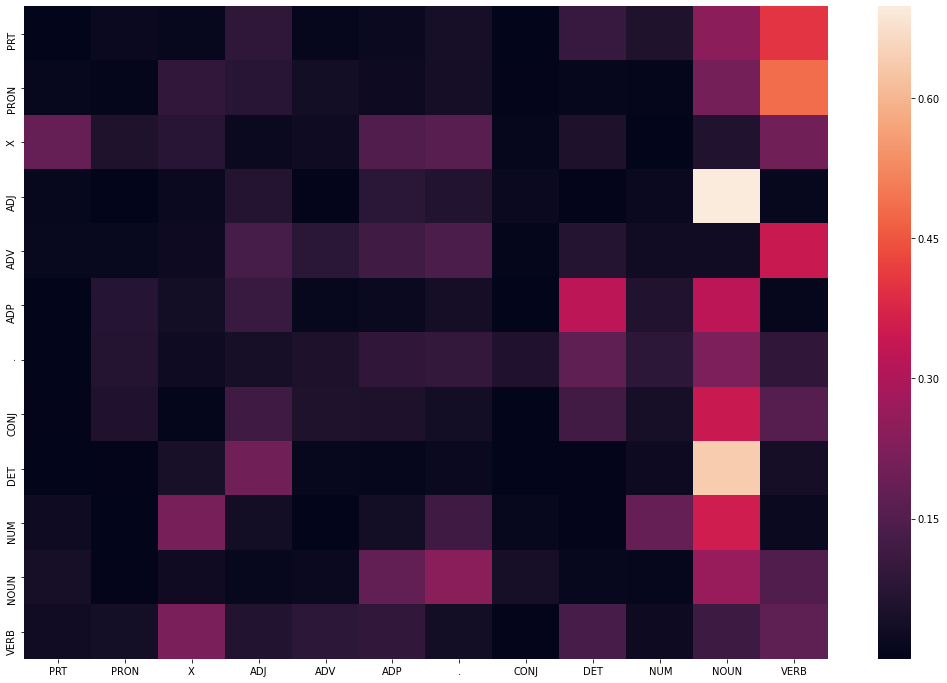

In [17]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()

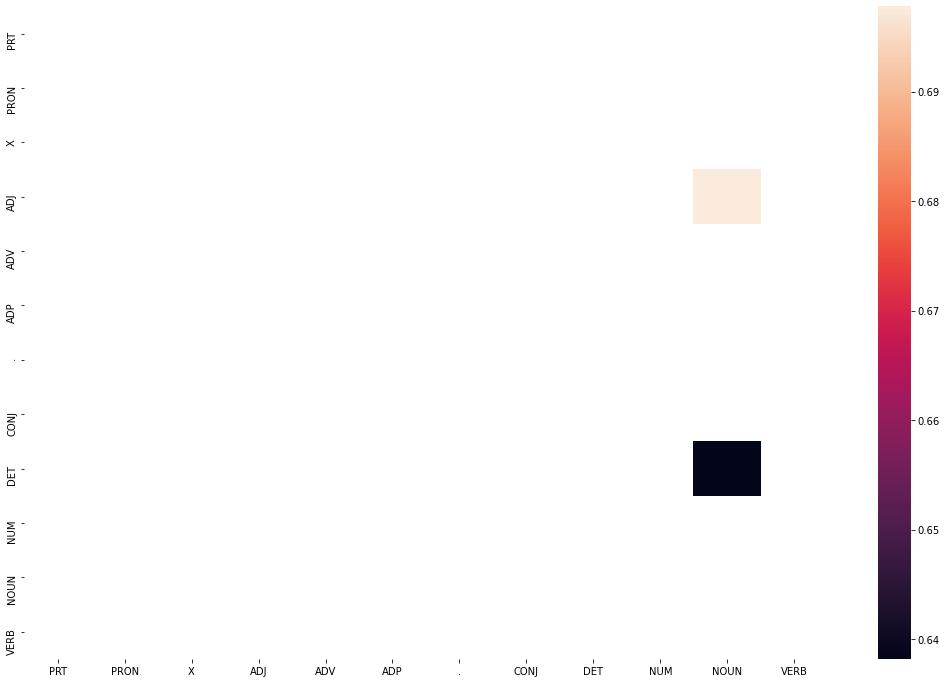

In [18]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

### Build the vanilla Viterbi based POS tagger

In [19]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [20]:
# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('For', 'ADP'),
  ('all', 'DET'),
  ('the', 'DET'),
  ('furor', 'NOUN'),
  (',', '.'),
  ('there', 'DET'),
  ('is', 'VERB'),
  ('nothing', 'NOUN'),
  ('particularly', 'ADV'),
  ('complex', 'ADJ'),
  ('about', 'ADP'),
  ('the', 'DET'),
  ('concept', 'NOUN'),
  ('of', 'ADP'),
  ('stock-index', 'ADJ'),
  ('arbitrage', 'NOUN'),
  (',', '.'),
  ('the', 'DET'),
  ('most', 'ADV'),
  ('controversial', 'ADJ'),
  ('type', 'NOUN'),
  ('of', 'ADP'),
  ('computer-assisted', 'ADJ'),
  ('program', 'NOUN'),
  ('trading', 'NOUN'),
  ('.', '.')],
 [('The', 'DET'),
  ('Santa', 'NOUN'),
  ('Ana', 'NOUN'),
  ('bonds', 'NOUN'),
  ('were', 'VERB'),
  ('tentatively', 'ADV'),
  ('priced', 'VERB'),
  ('*-1', 'X'),
  ('*-2', 'X'),
  ('to', 'PRT'),
  ('yield', 'VERB'),
  ('from', 'ADP'),
  ('6.40', 'NUM'),
  ('%', 'NOUN'),
  ('in', 'ADP'),
  ('1991', 'NUM'),
  ('to', 'PRT'),
  ('7.458', 'NUM'),
  ('%', 'NOUN'),
  ('in', 'ADP')],
 [('And', 'CONJ'),
  ('some', 'DET'),
  ('grain', 'NOUN'),
  ('analysts', 'NOUN'),


In [21]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start
print("Time taken in seconds: ", difference)
print(tagged_seq)

Time taken in seconds:  27.107125997543335
[('For', 'ADP'), ('all', 'DET'), ('the', 'DET'), ('furor', 'NOUN'), (',', '.'), ('there', 'DET'), ('is', 'VERB'), ('nothing', 'NOUN'), ('particularly', 'ADV'), ('complex', 'ADJ'), ('about', 'ADP'), ('the', 'DET'), ('concept', 'NOUN'), ('of', 'ADP'), ('stock-index', 'ADJ'), ('arbitrage', 'NOUN'), (',', '.'), ('the', 'DET'), ('most', 'ADJ'), ('controversial', 'ADJ'), ('type', 'NOUN'), ('of', 'ADP'), ('computer-assisted', 'ADJ'), ('program', 'NOUN'), ('trading', 'NOUN'), ('.', '.'), ('The', 'DET'), ('Santa', 'NOUN'), ('Ana', 'NOUN'), ('bonds', 'NOUN'), ('were', 'VERB'), ('tentatively', 'ADV'), ('priced', 'VERB'), ('*-1', 'X'), ('*-2', 'X'), ('to', 'PRT'), ('yield', 'VERB'), ('from', 'ADP'), ('6.40', 'NUM'), ('%', 'NOUN'), ('in', 'ADP'), ('1991', 'NUM'), ('to', 'PRT'), ('7.458', 'NUM'), ('%', 'NOUN'), ('in', 'ADP'), ('And', 'CONJ'), ('some', 'DET'), ('grain', 'NOUN'), ('analysts', 'NOUN'), ('are', 'VERB'), ('predicting', 'VERB'), ('that', 'ADP'), 

In [22]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy_viterbi = len(check)/len(tagged_seq)

print('Vanilla Viterbi Accuracy: ',accuracy_viterbi*100)

Vanilla Viterbi Accuracy:  89.5104895104895


In [23]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('the', 'DET'), (('most', 'ADJ'), ('most', 'ADV'))],
 [('might', 'VERB'), (('gyrate', 'PRT'), ('gyrate', 'VERB'))],
 [('exporters', 'NOUN'), (('scrounge', 'PRT'), ('scrounge', 'VERB'))],
 [('year', 'NOUN'), (('earlier', 'ADV'), ('earlier', 'ADJ'))],
 [('The', 'DET'), (('most', 'ADJ'), ('most', 'ADV'))],
 [('widely', 'ADV'), (('used', 'VERB'), ('used', 'ADJ'))],
 [('by', 'ADP'), (('Houghton', 'PRT'), ('Houghton', 'NOUN'))],
 [('Houghton', 'NOUN'), (('Mifflin', 'PRT'), ('Mifflin', 'NOUN'))],
 [('and', 'CONJ'), (('Harcourt', 'PRT'), ('Harcourt', 'NOUN'))],
 [('Harcourt', 'NOUN'), (('Brace', 'PRT'), ('Brace', 'NOUN'))],
 [('Brace', 'NOUN'), (('Jovanovich', 'PRT'), ('Jovanovich', 'NOUN'))],
 [("'s", 'PRT'), (('Metropolitan', 'PRT'), ('Metropolitan', 'NOUN'))],
 [('Metropolitan', 'NOUN'), (('Achievement', 'PRT'), ('Achievement', 'NOUN'))],
 [('and', 'CONJ'), (('Stanford', 'PRT'), ('Stanford', 'NOUN'))],
 [('Stanford', 'NOUN'), (('Achievement', 'PRT'), ('Achievement', 'NOUN'))]]

### Solve the problem of unknown words

## Modification Technique 1
When emission probaility is zero use the transition probability

In [24]:
def Viterbi_Tech1(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        p_transition =[] # list for storing transition probabilities
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            p_transition.append(transition_p)
            
        pmax = max(p)
        if pmax==0.0:
            state_max = T[p_transition.index(max(p_transition))]
            if state_max is None:
                state_max = "."
        else:
            state_max = T[p.index(pmax)] 
        
        state.append(state_max)
    return list(zip(words, state))

In [25]:
# tagging the test sentences
start = time.time()
tagged_seq =  Viterbi_Tech1(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)
print(tagged_seq)

Time taken in seconds:  26.16565775871277
[('For', 'ADP'), ('all', 'DET'), ('the', 'DET'), ('furor', 'NOUN'), (',', '.'), ('there', 'DET'), ('is', 'VERB'), ('nothing', 'NOUN'), ('particularly', 'ADV'), ('complex', 'ADJ'), ('about', 'ADP'), ('the', 'DET'), ('concept', 'NOUN'), ('of', 'ADP'), ('stock-index', 'ADJ'), ('arbitrage', 'NOUN'), (',', '.'), ('the', 'DET'), ('most', 'ADJ'), ('controversial', 'ADJ'), ('type', 'NOUN'), ('of', 'ADP'), ('computer-assisted', 'ADJ'), ('program', 'NOUN'), ('trading', 'NOUN'), ('.', '.'), ('The', 'DET'), ('Santa', 'NOUN'), ('Ana', 'NOUN'), ('bonds', 'NOUN'), ('were', 'VERB'), ('tentatively', 'ADV'), ('priced', 'VERB'), ('*-1', 'X'), ('*-2', 'X'), ('to', 'PRT'), ('yield', 'VERB'), ('from', 'ADP'), ('6.40', 'NUM'), ('%', 'NOUN'), ('in', 'ADP'), ('1991', 'NUM'), ('to', 'PRT'), ('7.458', 'NUM'), ('%', 'NOUN'), ('in', 'ADP'), ('And', 'CONJ'), ('some', 'DET'), ('grain', 'NOUN'), ('analysts', 'NOUN'), ('are', 'VERB'), ('predicting', 'VERB'), ('that', 'ADP'), (

In [26]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
Viterbi_Tech1_Accuracy = len(check)/len(tagged_seq)
print('Vanilla Viterbi for Unknown Words Accuracy: ',Viterbi_Tech1_Accuracy*100)

Vanilla Viterbi for Unknown Words Accuracy:  93.7062937062937


## Modification Technique 2

Let's combining the taggers. combining the Rule Based Tagger with Unigram Tagger for solve the problem of Unknown words

In [27]:
def unigramtagger(word,train_set = train_set):
    patterns = [
    (r'.*ing$', 'VERB'),              # gerund
    (r'.*ed$', 'VERB'),               # past tense
    (r'.*es$', 'VERB'),               # 3rd singular present
    (r'.*ould$', 'X'),                # modals
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers
    (r'.*', 'NOUN')                    # nouns
    ]
    regex_based_tagger = nltk.RegexpTagger(patterns)

    unigram_regex_tagger = nltk.UnigramTagger(train_set, backoff=regex_based_tagger)
    return unigram_regex_tagger.tag_sents([[(word)]])

In [28]:
def Viterbi_Tech2(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):

        if word not in tokens:
            unknown_word_tag=unigramtagger(word)
            for sent in unknown_word_tag:
                for tup in sent:
                    state.append(tup[1])           
        else:            
            p = [] 
            for tag in T:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
                state_probability = emission_p * transition_p    
                p.append(state_probability)
            
            pmax = max(p)
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
            state.append(state_max)
            
    return list(zip(words, state))

In [29]:
start = time.time()
tagged_seq = Viterbi_Tech2(test_tagged_words)
end = time.time()
difference = end-start

In [30]:
check1 = [i for i, j in zip(tagged_seq, test_run_base) if i == j]
Viterbi_Tech2_Accuracy = len(check1)/len(tagged_seq)
print('Vanilla Viterbi for Rule based And Unigram Tagger Accuracy: ',Viterbi_Tech2_Accuracy*100)

Vanilla Viterbi for Rule based And Unigram Tagger Accuracy:  95.8041958041958


### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [31]:
accuracy_list = [['Vanilla Viterbi',accuracy_viterbi*100],
                 ['Viterbi_Tech1',Viterbi_Tech1_Accuracy*100],
                 ['Viterbi_Tech2',Viterbi_Tech2_Accuracy*100]]

In [32]:
df = pd.DataFrame(accuracy_list, columns = ['Algorithm', 'Accuracy'])
df.set_index('Algorithm', drop = True, inplace = True)
df

,Accuracy
Algorithm,
Vanilla Viterbi,89.510490
Viterbi_Tech1,93.706294
Viterbi_Tech2,95.804196


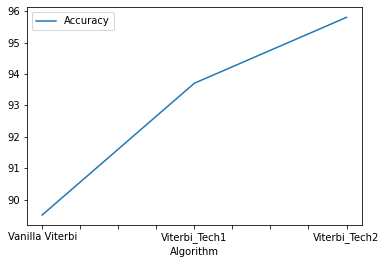

In [33]:
df.plot.line()

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [34]:
## Testing with the test sentences
with open('Test_sentences.txt', 'r') as file:
    sentences = file.read()

print(sentences)

Android is a mobile operating system developed by Google.
Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.
Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.
Twitter is an online news and social networking service on which users post and interact with messages known as tweets.
Before entering politics, Donald Trump was a domineering businessman and a television personality.
The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.
This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.
Show me the cheapest round trips from Dallas to Atlanta
I would like to see flights from Denver to Philadelphia.
Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.
NASA invited social media users to experience the launch of ICESAT-2 Satellite.






## Case 1

In [35]:
sentence_1 = 'Android is a mobile operating system developed by Google.'
words = word_tokenize(sentence_1)
tagged_seq = Viterbi(words)
print(tagged_seq)

[('Android', 'PRT'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'PRT'), ('.', '.')]


In [36]:
tagged_seq_modified = Viterbi_Tech2(words)
print(tagged_seq_modified)

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.')]


## Case 2

In [37]:
sentence_2 = 'Google and Twitter made a deal in 2015 that gave Google access to Twitter firehose.'
words = word_tokenize(sentence_2)
tagged_seq = Viterbi(words)
print(tagged_seq)

[('Google', 'PRT'), ('and', 'CONJ'), ('Twitter', 'PRT'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'PRT'), ('that', 'DET'), ('gave', 'VERB'), ('Google', 'PRT'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'PRT'), ('firehose', 'PRT'), ('.', '.')]


In [38]:
tagged_seq_modified = Viterbi_Tech2(words)
print(tagged_seq_modified)

[('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ('firehose', 'NOUN'), ('.', '.')]


## Case 3

In [39]:
sentence_3 = 'NASA invited social media users to experience the launch of ICESAT-2 Satellite.'
words = word_tokenize(sentence_3)
tagged_seq = Viterbi(words)
print(tagged_seq)

[('NASA', 'PRT'), ('invited', 'PRT'), ('social', 'ADJ'), ('media', 'NOUN'), ('users', 'NOUN'), ('to', 'PRT'), ('experience', 'NOUN'), ('the', 'DET'), ('launch', 'NOUN'), ('of', 'ADP'), ('ICESAT-2', 'PRT'), ('Satellite', 'PRT'), ('.', '.')]


In [40]:
tagged_seq_modified = Viterbi_Tech2(words)
print(tagged_seq_modified)

[('NASA', 'NOUN'), ('invited', 'VERB'), ('social', 'ADJ'), ('media', 'NOUN'), ('users', 'NOUN'), ('to', 'PRT'), ('experience', 'NOUN'), ('the', 'DET'), ('launch', 'NOUN'), ('of', 'ADP'), ('ICESAT-2', 'NOUN'), ('Satellite', 'NOUN'), ('.', '.')]
